In [372]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import torch

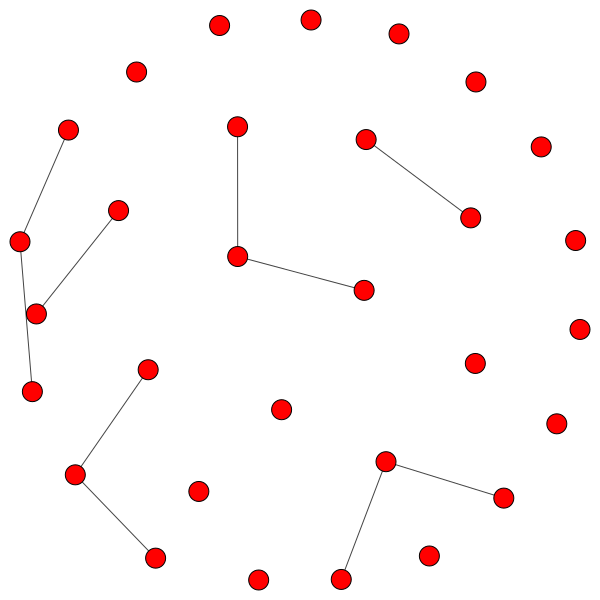

In [373]:
g = ig.Graph.Erdos_Renyi(n = 30, m = 10)
layout = g.layout('kk')
ig.plot(g, layout = layout)

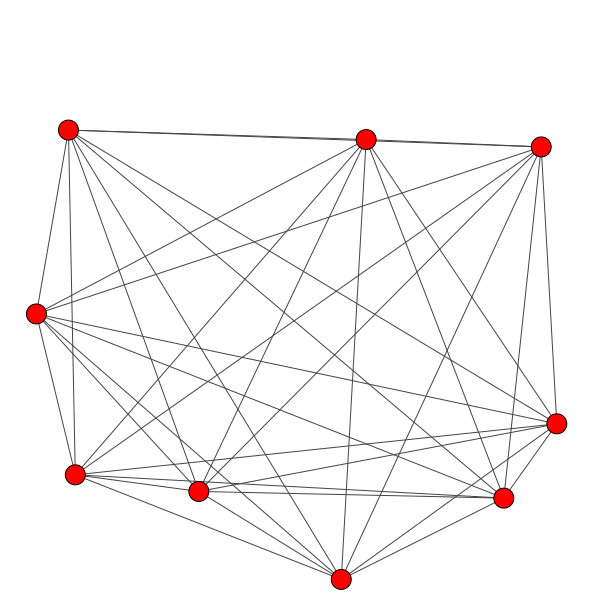

In [463]:
g = ig.Graph.Full(9)
# g.add_vertices(1)
ig.plot(g, layout = layout)

In [456]:
# g.add_vertices(1)

In [464]:
adjM = torch.autograd.Variable(torch.Tensor(g.get_adjacency().data), requires_grad = True)
N = adjM.shape[0]

# get Laplacian
L = torch.diag(torch.matmul(adjM, torch.ones(N))) - adjM
L_mod = L + torch.ones_like(L)/N

# calculate log dets
eps = 10e-6
print(-torch.logdet(L_mod))
print(-torch.logdet(L_mod + eps * torch.eye(N)))

tensor(-17.5778, grad_fn=<NegBackward>)
tensor(-17.5778, grad_fn=<NegBackward>)


In [465]:
torch.det(L_mod)

tensor(43046732., grad_fn=<DetBackward>)

In [466]:
eigvals = torch.symeig(L_mod)[0]
eigvals.data

tensor([1.0000, 9.0000, 9.0000, 9.0000, 9.0000, 9.0000, 9.0000, 9.0000, 9.0000])

In [467]:
eigvals = torch.symeig(L_mod)[0]
eigvals.data

tensor([1.0000, 9.0000, 9.0000, 9.0000, 9.0000, 9.0000, 9.0000, 9.0000, 9.0000])

In [468]:
torch.log(100 * torch.clamp(eigvals, max = 0.01) + 0.01)

tensor([0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100, 0.0100],
       grad_fn=<LogBackward>)

In [469]:
v = eigvals
tau = 0.1

torch.where(v < tau, 
        v**2/2-v + tau - tau*tau/2,
        torch.scalar_tensor(0, device = v.device).expand_as(v))

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.], grad_fn=<SWhereBackward>)

# Implement on our dataset

In [381]:
import os
if "ntbk" in os.getcwd():
    os.chdir("..")
print(os.getcwd())

import sys
sys.path.append(os.path.join(os.getcwd(), "otgnn"))


%load_ext autoreload
%autoreload 2

from otgnn.models import GCN
from otgnn.graph import MolGraph
from otgnn.utils import save_model, load_model
from otgnn.graph import SYMBOLS, FORMAL_CHARGES, BOND_TYPES, get_bt_index

from mol_opt.mol_opt import MolOpt
from mol_opt.data_mol_opt import MolOptDataset
from mol_opt.data_mol_opt import get_loader
from mol_opt.decoder_mol_opt import MolOptDecoder
from mol_opt.arguments import get_args
from mol_opt.train_mol_opt import main, get_latest_model
from mol_opt.ot_utils import encode_target, FGW
from mol_opt.train_mol_opt import ft
from mol_opt.ot_utils import Penalty as PenaltyOld

from rdkit.Chem import MolFromSmiles

from molgen.metrics.Penalty import Penalty as PenaltyNew

import torch
from torch import nn
import numpy as np
import time

/home/octav/gitrepos/tum-thesis
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [382]:
data_loader = get_loader("iclr19-graph2graph/data/qed", "val", 96, False)
for i in data_loader:
    X = (MolGraph(i[0]))
    Y = (MolGraph(i[1]))
    break

In [383]:
sys.argv = ["", "-cuda"]
args = get_args()
args.output_dir = "mol_opt/output/"

mol_opt = MolOpt(args)
mol_opt_decoder = MolOptDecoder(args)
loss = FGW(alpha = 0.5)

In [384]:
x_embedding, x_delta_hat = mol_opt.forward(X)
yhat_embedding = x_embedding + x_delta_hat
yhat_logits = mol_opt_decoder.forward(yhat_embedding, Y)
yhat_labels = mol_opt_decoder.discretize(*yhat_logits)

pred_pack = (yhat_labels, yhat_logits, Y.scope), Y
loss(*pred_pack).item() / 96

/home/octav/gitrepos/tum-thesis/otgnn/models/gromov_modules.py:394: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  nce_reg = torch.nn.LogSoftmax()(torch.stack(all_nce_dists))[0]


3.738100051879883

In [385]:
loss(*pred_pack)

tensor(358.8576, device='cuda:0', grad_fn=<AddBackward0>)

In [386]:
pen.BOND_TYPES

[rdkit.Chem.rdchem.BondType.SINGLE,
 rdkit.Chem.rdchem.BondType.DOUBLE,
 rdkit.Chem.rdchem.BondType.TRIPLE,
 rdkit.Chem.rdchem.BondType.AROMATIC,
 None]

In [387]:
args

Namespace(N_transformer=6, agg_func='sum', annealing_rate=0.05, batch_norm=False, connectivity=True, connectivity_hard=True, connectivity_lambda=0.5, cuda=True, device='cuda:0', dim_tangent_space=40, dropout_ffn=0.0, dropout_gcn=0.0, dropout_transformer=0.1, euler_characteristic_penalty=True, euler_lambda=0.0015, ffn_activation='LeakyReLU', init_decoder_model=None, init_model=None, linear_out=False, n_epochs=10, n_ffn_hidden=100, n_ffn_transformer=100, n_heads_transformer=10, n_hidden=50, n_labels=1, n_layers=5, ot_solver='emd', output_dir='mol_opt/output/', pc_hidden=50, pred_hidden=100, sinkhorn_entropy=0.1, sinkhorn_max_it=10000, task='qed', valency=True, valency_hard=False, valency_lambda=0.01)

In [388]:
symbols_logits, charges_logits, bonds_logits = yhat_logits

In [389]:
bonds_logits.shape

torch.Size([44494, 5])

In [444]:
pen = PenaltyNew(args, prev_epoch = 30)
pen(*pred_pack, 0)

TypeError: __call__() takes 4 positional arguments but 5 were given

In [443]:
pen.tau

0.21463876394293727

In [392]:
pen.annealing_rate

0.05

In [394]:
pen2 = PenaltyOld()
pen2(*pred_pack) * 0.015

tensor(-83.6772, device='cuda:0', grad_fn=<MulBackward0>)

In [395]:
bond_idx = 0
num_atoms = 22
adjM = bonds_soft[bond_idx:bond_idx+num_atoms*num_atoms].view(num_atoms, num_atoms, -1)

NameError: name 'bonds_soft' is not defined

In [396]:
1 - adjM[:,:,-1]

IndexError: too many indices for tensor of dimension 2

In [397]:
adjM[0,1,:]

IndexError: too many indices for tensor of dimension 2

In [398]:
adjM.shape

torch.Size([11, 11])

In [399]:
bonds_soft.shape

NameError: name 'bonds_soft' is not defined

In [400]:
bonds_logits[1,:]

tensor([ 0.1585, -0.1359,  0.0210,  0.1341,  0.0276], device='cuda:0',
       grad_fn=<SliceBackward>)

In [401]:
bonds_soft[:,-1]

NameError: name 'bonds_soft' is not defined

In [402]:
bonds_soft = 1-nn.functional.gumbel_softmax(logits = adjM, hard = True, dim = 2)[:,:,-1]

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [ ]:
adjM.shape

In [ ]:
bonds_soft

# Implement new function

In [403]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')

def phi(t, tau):
    if t < tau:
        return t*t/2 - t
    else:
        return -(1-tau)**2 * np.log((1-2*tau+t)/(1-tau))-tau + tau*tau/2
#         return -tau + tau*tau/2

def phi2(t, tau):
    return max(0, t**2/2-t + tau - tau*tau/2)

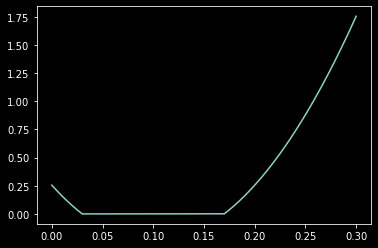

In [404]:
rgx = np.linspace(0,0.3,50000)
rgy = np.array([phi2(10*t, 0.3) for t in rgx])
plt.plot(rgx, rgy)
plt.show()

In [405]:
eigvals ** 2 /2 - eigvals

tensor([ 4.3028e-07, -3.7253e-08, -5.0000e-01,  3.1500e+01,  3.1500e+01,
         3.1500e+01,  3.1500e+01,  3.1500e+01,  3.1500e+01,  3.1500e+01,
         3.1500e+01], grad_fn=<SubBackward0>)

In [406]:
eigvals

tensor([-4.3028e-07,  3.7253e-08,  1.0000e+00,  9.0000e+00,  9.0000e+00,
         9.0000e+00,  9.0000e+00,  9.0000e+00,  9.0000e+00,  9.0000e+00,
         9.0000e+00], grad_fn=<SymeigBackward>)

In [407]:
v = eigvals
tau = 0.1

def eigval_rescale(v, tau):
    return torch.where(v < tau, v**2/2-v,-(1-v)**2 * torch.log((1-2*tau+v)/(1-tau))-tau + tau*tau/2)

In [408]:
torch.sum(eigval_rescale(eigvals, 0.99))

tensor(-3428.2996, grad_fn=<SumBackward0>)

In [409]:
eigval_rescale(eigvals, 0.99)

tensor([ 4.3028e-07, -3.7253e-08, -4.9995e-01, -4.2847e+02, -4.2847e+02,
        -4.2847e+02, -4.2847e+02, -4.2847e+02, -4.2848e+02, -4.2848e+02,
        -4.2848e+02], grad_fn=<SWhereBackward>)

In [410]:
tau

0.1

In [411]:
torch.scalar_tensor(tau).expand_as(v)

tensor([0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
        0.1000, 0.1000])

In [412]:
torch.clamp(v-tau, min = 0)

tensor([0.0000, 0.0000, 0.9000, 8.9000, 8.9000, 8.9000, 8.9000, 8.9000, 8.9000,
        8.9000, 8.9000], grad_fn=<ClampBackward>)

In [413]:
torch.clamp(v*v/2-v+tau-tau*tau/2, min = 0)

tensor([ 0.0950,  0.0950,  0.0000, 31.5950, 31.5950, 31.5950, 31.5950, 31.5950,
        31.5950, 31.5950, 31.5950], grad_fn=<ClampBackward>)

In [414]:
torch.where(v < tau, 
        v**2/2-v + tau - tau*tau/2,
        torch.scalar_tensor(0, device = v.device).expand_as(v))

tensor([0.0950, 0.0950, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], grad_fn=<SWhereBackward>)

# Validate penalty code on real molecules. All penalties should be 0, in that case

In [415]:
from mol_opt.ot_utils import encode_target

symbols_logits, bonds_logits = encode_target(X, device = 'cuda')
symbols_labels, charges_labels, bonds_labels = mol_opt_decoder.discretize(symbols_logits, symbols_logits, bonds_logits)
pred_pack = _, (symbols_logits, _, bonds_logits), X.scope

In [416]:
bonds_logits

tensor([[0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        ...,
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.]], device='cuda:0')

In [417]:
prediction = pred_pack
target_batch = X
epochidx = 0
pen(pred_pack, X, 0)

(tensor(4.9064, device='cuda:0'),
 tensor(615.6127, device='cuda:0'),
 tensor(32.3584, device='cuda:0'))

In [418]:
from rdkit import Chem

maxValency = []
for sym in SYMBOLS:
    if sym == 'UNK':
        maxValency.append(10000)
    else:
        maxValency.append(Chem.GetPeriodicTable().GetValenceList(sym)[-1])
maxValency = torch.tensor(maxValency)

bond_weights = torch.tensor([1., 2., 3., 1., 0.], dtype=torch.float)

In [419]:

# Unpack inputs
device = bonds_logits.device

# bonds_prob = torch.nn.functional.gumbel_softmax(logits=bonds_logits, hard=False, tau=1, dim=1)
# symbols_prob = torch.nn.functional.gumbel_softmax(logits=symbols_logits, hard=False, tau=1, dim=1)
bonds_prob = bonds_logits
symbols_prob = symbols_logits
bonds_prob_conn = bonds_prob

bonds_exist_prob = 1 - bonds_prob_conn[:,-1]
con_loss = torch.tensor(0., device=device) # reconstruction loss
val_loss = torch.tensor(0., device=device) # reconstruction loss
eul_loss = torch.tensor(0., device=device) # reconstruction loss
for st, le in X.scope:
    bond_idx = 0
    
    # Metric cost matrix for nodes
    pred_bonds = bonds_exist_prob[bond_idx:bond_idx+le*le].view(le, le) # le^2 predictions for all the possible bonds
    con_loss += pen.conn_penalty(pred_bonds) * pen.conn_lambda
    
    if bond_weights.device != device:
        bond_weights = bond_weights.to(device)
    if maxValency.device != device:
        maxValency = maxValency.to(device)
    syms = symbols_prob[st:st+le]
    adj = bonds_prob[bond_idx:bond_idx+le*le].view(le, le, -1)
    for idx, symbol_probs in enumerate(syms):
        effValency = torch.sum(adj[idx] * bond_weights)
        # Expected maximum valency
        maxVal = torch.sum(symbol_probs[:-1] * maxValency[:-1])
        if maxVal > 0 and maxVal < effValency:
            val_loss += (effValency - maxVal) * pen.valency_lambda
        if effValency < 1:
            val_loss += (1 - effValency) * pen.valency_lambda
            
    # Using the bonds, the number of edges needs to be from |V|-1 to |V|+5
    expected_num_edges = torch.sum(pred_bonds)/2
    V = le
    if expected_num_edges < V - 1:
        eul_loss += pen.euler_lambda * (V - 1 - expected_num_edges)
    if expected_num_edges > V + 5:
        eul_loss += pen.euler_lambda * (expected_num_edges - V - 5)
        
    bond_idx += le * le
    
    break
print(con_loss, val_loss, eul_loss)

tensor(0.5849, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')


In [421]:
pen.conn_penalty(pred_bonds)

tensor(0.7182, device='cuda:0')

In [429]:
adjM = pred_bonds
N = adjM.shape[0]
device = adjM.device

# get Laplacian
L = torch.diag(torch.matmul(adjM, torch.ones(N, device=device))) - adjM
L_mod = L + torch.ones_like(L, device=device) / N
eigvals = torch.symeig(L_mod, eigenvectors = True)[0]

In [438]:
from molgen.metrics.Penalty import eigval_rescale

eigval_rescale(eigvals, 0.05)

tensor([0.0146, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000], device='cuda:0')

In [436]:
eigvals

tensor([0.0347, 0.0869, 0.2137, 0.3023, 0.4129, 0.6035, 0.9205, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.3630, 1.3984, 1.5395, 2.1739, 2.4458, 2.7993,
        3.0000, 3.0000, 3.2518, 3.3731, 3.5386, 4.0963, 4.2686, 4.4950, 4.5294,
        4.9983, 5.1542], device='cuda:0')

In [440]:
pen.tau

0.5987369392383787

In [ ]:
from rdkit.Chem.Draw import IPythonConsole
X.rd_mols[0]